# Item Scraper

This jupyter notebook file contains the code used for scraping vinyl record data from amazon.ca to be analyzed

In [153]:
# importing libraries
from bs4 import BeautifulSoup
import requests
import time
import datetime
import pandas as pd

import smtplib  #for sending emails
import os
from email.message import EmailMessage
import imghdr

# Setting environment variables for email address and password

## Create csv to append entries to

In [249]:
import csv

header = ['Artist', 'Album', "Rating", "Number of Ratings", "Price", "DoubleLP", "Date", 'URL']

# commented out to not overwite data
# with open('webscraping_amazon_vinyl.csv', 'w', newline='', encoding='UTF8') as f:
#     writer = csv.writer(f)
#     writer.writerow(header)
#     # writer.writerow(data)

In [251]:
urls = {"Weezer-Blue-Ablum":'https://www.amazon.ca/Weezer-Blue-Album-Vinyl/dp/B01L2ZS87S/ref=asc_df_B01L2ZS87S/?tag=googleshopc0c-20&linkCode=df0&hvadid=292997009494&hvpos=&hvnetw=g&hvrand=17970184648922962140&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=1002283&hvtargid=pla-439544140972&psc=1',
        "Weezer-Pinkerton":'https://www.amazon.ca/Pinkerton-Vinyl-Weezer/dp/B01L2ZS882/ref=sr_1_1?crid=22OIHD8RFNDCH&keywords=weezer+pinkerton&qid=1653680516&s=music&sprefix=weezer+pinkerton%2Cpopular%2C84&sr=1-1',
        "Fleet-Foxes-Crack-Up":'https://www.amazon.ca/Crack-Up-Vinyl-Fleet-Foxes/dp/B06XGN3ZD5/ref=sr_1_5?crid=3FHPTOIY9OSAK&keywords=fleet+foxes+helplessness+blues+vinyl&qid=1653680596&s=music&sprefix=fleet+foxes+helplessness+blues+vinyl%2Cpopular%2C88&sr=1-5',
        "The Cure-Head on the Door":'https://www.amazon.ca/Head-Door-Vinyl-Cure/dp/B000091EQO/ref=sr_1_3?crid=TN45MHTNELRL&keywords=the+cure+vinyl&qid=1653680657&s=music&sprefix=the+cure+vinyl%2Cpopular%2C79&sr=1-3'
}

for value in urls.values():
    update_price(value)

## Function to Scrape Data From Each url Provided

In [290]:
def update_price(url):

    # setting up the BeatifulSoup object
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.content, "html.parser")

    # scrape data

    # meta info
    title = soup.find(id = 'productTitle').get_text().strip()
    artist = soup.find('span', class_="author notFaded").find('a', class_='a-link-normal').get_text().strip()
    rating = soup.find('span', class_='a-icon-alt').get_text().strip().split()[0]
    num_ratings = soup.find(id = 'acrCustomerReviewText').get_text().strip().split()[0]
    
    # if price does not exist, fill with "None"
    try:
        price = float(soup.find('span', class_='a-offscreen').get_text().strip()[1:])
    except ValueError:
        return None

    # return the number of LPs. Could compare with price single vs double
    info = soup.find('ul', class_='a-unordered-list a-nostyle a-vertical a-spacing-none detail-bullet-list').get_text().strip().split()
    lp_num = int(info[-1])
    if lp_num == 2:
        doublelp = True
    else:
        doublelp = False

    # scrape date
    today = datetime.date.today()

    link = url

    # set up list of variables to be appeded to existing pandas data.frame
    header = ['Artist', 'Album', "Rating", "Number of Ratings", "Price", "LPs", "Date", 'url']
    data = [artist, title, rating, num_ratings, price, lp_num, today, link]

    with open('webscraping_amazon_vinyl.csv', 'a+', newline='', encoding='UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(data)

## Funciton Send Ourselves an Email

In [289]:

def send_mail(album, type='drop'):
    email_address = os.environ.get('email_user')
    email_password = os.environ.get('user_pass')

    band_name = album.iloc[0,0]
    album_name = album.iloc[0,1]
    item_link = album.iloc[0,-1]

    price_history = sns.relplot(data=album, x='Date', y='Price',
            kind='line').set(
                title='Price History of ' + album_name + ' by ' + band_name
            )
    
    price_history.savefig("price_history.jpg")

    
    msg = EmailMessage()

    if type == "drop":

        old_price = album.iloc[-2,4]
        new_price = album.iloc[-1,4]

        msg['Subject'] = album_name + ' by the ' + band_name + ' has Dropped in Price!'
        msg['From'] = email_address
        msg['To'] = 'mitchbrownuw@gmail.com'
        msg.set_content('A Vinyl Record you were watching has seen a considerable change in price! Now is your time to pick it up!\n\n' + album_name + ' by the ' + band_name + ' has gone from $' + str(old_price) + " to $" + str(new_price) + ' pick it up here: ' +  str(item_link))

    if type == "available":

        new_price = album.iloc[-1,4]

        msg['Subject'] = album_name + ' by the ' + band_name + ' is Available Again'
        msg['From'] = email_address
        msg['To'] = 'mitchbrownuw@gmail.com'
        msg.set_content('A Vinyl Record you were watching has become available again! Now is your time to pick it up!\n\n' + album_name + ' by the ' + band_name + ' is now available at $' + str(new_price) + ' pick it up here: ' +  str(item_link))

    # if we want to attach multiple files
    files = ['price_history.jpg']

    # attaching images to the email containing the price history of the vinyl
    for file in files:
        with open(file, 'rb') as f:
            file_data = f.read()
            file_type = imghdr.what(f.name)     # tells us the file type of the image (useful if printing multiple images)
            file_name = f.name

        # attach images to message
        msg.add_attachment(file_data, maintype='image', subtype=file_type, filename=file_name)

    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(email_address, email_password)       # log into our mail server

        smtp.send_message(msg)

## Make a Master function to scrape the data and send and email if there is a price change

In [286]:
def price_tracker(items, df):
    for value in items.values():
        update_price(value)

    for album in df['Album'].unique():
        single_album = df[df['Album'] == album]

        if (len(single_album) > 1) and (single_album.iloc[-1,4] != None) and (single_album.iloc[-1,4] != None):
            if ((single_album.iloc[-1,4] - single_album.iloc[-2,4]) < -0.5):
                send_mail(single_album)
        elif (single_album.iloc[-2,4] == None) and (single_album.iloc[-1,4] != None):
            send_mail(single_album, type='available')

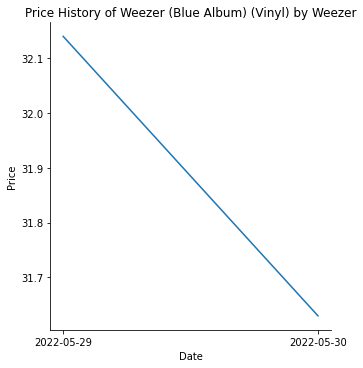

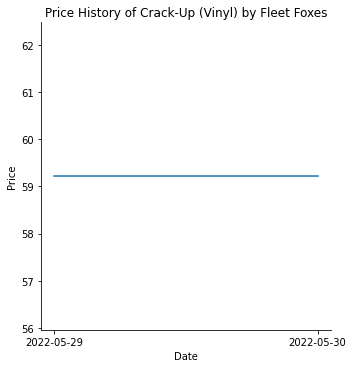

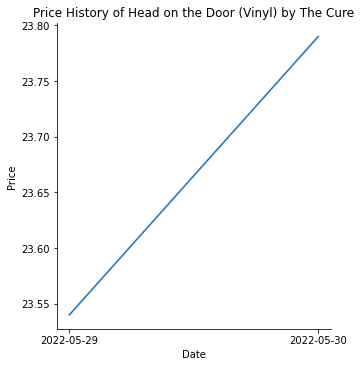

In [287]:
urls = {"Weezer-Blue-Ablum":'https://www.amazon.ca/Weezer-Blue-Album-Vinyl/dp/B01L2ZS87S/ref=asc_df_B01L2ZS87S/?tag=googleshopc0c-20&linkCode=df0&hvadid=292997009494&hvpos=&hvnetw=g&hvrand=17970184648922962140&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=1002283&hvtargid=pla-439544140972&psc=1',
        "Weezer-Pinkerton":'https://www.amazon.ca/Pinkerton-Vinyl-Weezer/dp/B01L2ZS882/ref=sr_1_1?crid=22OIHD8RFNDCH&keywords=weezer+pinkerton&qid=1653680516&s=music&sprefix=weezer+pinkerton%2Cpopular%2C84&sr=1-1',
        "Fleet-Foxes-Crack-Up":'https://www.amazon.ca/Crack-Up-Vinyl-Fleet-Foxes/dp/B06XGN3ZD5/ref=sr_1_5?crid=3FHPTOIY9OSAK&keywords=fleet+foxes+helplessness+blues+vinyl&qid=1653680596&s=music&sprefix=fleet+foxes+helplessness+blues+vinyl%2Cpopular%2C88&sr=1-5',
        "The Cure-Head on the Door":'https://www.amazon.ca/Head-Door-Vinyl-Cure/dp/B000091EQO/ref=sr_1_3?crid=TN45MHTNELRL&keywords=the+cure+vinyl&qid=1653680657&s=music&sprefix=the+cure+vinyl%2Cpopular%2C79&sr=1-3'
}

price_tracker(urls, df)

In [272]:
df = pd.read_csv('webscraping_amazon_vinyl.csv')
df.dtypes

Artist                object
Album                 object
Rating               float64
Number of Ratings     object
Price                float64
DoubleLP               int64
Date                  object
URL                   object
dtype: object

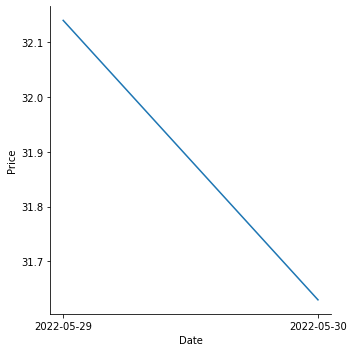

In [277]:
single_album = df[df['Artist'] == 'Weezer']

single_album

price_history = sns.relplot(data=single_album, x='Date', y='Price',
            kind='line')

In [278]:
df

,Artist,Album,Rating,Number of Ratings,Price,DoubleLP,Date,URL
0,Weezer,Weezer (Blue Album) (Vinyl),4.7,"4,103",32.14,1,2022-05-29,https://www.amazon.ca/Weezer-Blue-Album-Vinyl/...
1,Fleet Foxes,Crack-Up (Vinyl),4.4,368,59.22,2,2022-05-29,https://www.amazon.ca/Crack-Up-Vinyl-Fleet-Fox...
2,The Cure,Head on the Door (Vinyl),4.8,"1,223",23.54,1,2022-05-29,https://www.amazon.ca/Head-Door-Vinyl-Cure/dp/...
3,Weezer,Weezer (Blue Album) (Vinyl),4.7,"4,103",32.14,1,2022-05-29,https://www.amazon.ca/Weezer-Blue-Album-Vinyl/...
4,Fleet Foxes,Crack-Up (Vinyl),4.4,368,59.22,2,2022-05-29,https://www.amazon.ca/Crack-Up-Vinyl-Fleet-Fox...
5,The Cure,Head on the Door (Vinyl),4.8,"1,223",23.54,1,2022-05-29,https://www.amazon.ca/Head-Door-Vinyl-Cure/dp/...
6,Weezer,Weezer (Blue Album) (Vinyl),4.7,"4,103",32.14,1,2022-05-29,https://www.amazon.ca/Weezer-Blue-Album-Vinyl/...
7,Fleet Foxes,Crack-Up (Vinyl),4.4,368,59.22,2,2022-05-29,https://www.amazon.ca/Crack-Up-Vinyl-Fleet-Fox...
8,The Cure,Head on the Door (Vinyl),4.8,"1,223",23.54,1,2022-05-29,https://www.amazon.ca/Head-Door-Vinyl-Cure/dp/...
9,Weezer,Weezer (Blue Album) (Vinyl),4.7,"4,103",32.14,1,2022-05-29,https://www.amazon.ca/Weezer-Blue-Album-Vinyl/...
